In [32]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [33]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DXG Historical Data 1_6.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [34]:
df1=df.reset_index()['Price']
df1.head()

0    13401.4
1    13371.1
2    13522.4
3    13159.4
4    14066.9
Name: Price, dtype: float64

In [35]:
df1

0       13401.4
1       13371.1
2       13522.4
3       13159.4
4       14066.9
         ...   
1593    16550.0
1594    16800.0
1595    16850.0
1596    16850.0
1597    16800.0
Name: Price, Length: 1598, dtype: float64

In [36]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [37]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [38]:
test_size

159

In [39]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [40]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [41]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
X_train.shape

(1337, 100, 1)

In [43]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 22ms/step - loss: 0.0127
Epoch 2/100
21/21 [==============================] - 0s 21ms/step - loss: 0.0017
Epoch 3/100
21/21 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 4/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0012
Epoch 5/100
21/21 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 6/100
21/21 [==============================] - 0s 21ms/step - loss: 0.0010
Epoch 7/100
21/21 [==============================] - 0s 20ms/step - loss: 9.1970e-04
Epoch 8/100
21/21 [==============================] - 0s 22ms/step - loss: 8.6662e-04
Epoch 9/100
21/21 [==============================] - 0s 21ms/step - loss: 8.8307e-04
Epoch 10/100
21/21 [==============================] - 0s 22ms/step - loss: 7.7865e-04
Epoch 11/100
21/21 [==============================] - 0s 21ms/step - loss: 7.7307e-04
Epoch 12/100
21/21 [==============================] - 0s 21ms/step - loss: 7.3271e-04
E

In [45]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 11ms/step


In [46]:
# 11. Chuẩn hóa dữ liệu y_pred, y_test
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [47]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 489.62291528891836


In [48]:
# 13. Dự báo 30 ngày tiếp theo (test có 159 ngày)
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.25279737]
101
[0.25279737]
102
[0.25279737]
103
[0.25279737]
104
[0.25279737]
105
[0.25279737]
106
[0.25279737]
107
[0.25279737]
108
[0.25279737]
109
[0.25279737]
110
[0.25279737]
111
[0.25279737]
112
[0.25279737]
113
[0.25279737]
114
[0.25279737]
115
[0.25279737]
116
[0.25279737]
117
[0.25279737]
118
[0.25279737]
119
[0.25279737]
120
[0.25279737]
121
[0.25279737]
122
[0.25279737]
123
[0.25279737]
124
[0.25279737]
125
[0.25279737]
126
[0.25279737]
127
[0.25279737]
128
[0.25279737]
129
[0.25279737]
130


In [49]:
# 13b. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.25279737]
101
[0.25279737]
102
[0.25279737]
103
[0.25279737]
104
[0.25279737]
105
[0.25279737]
106
[0.25279737]
107
[0.25279737]
108
[0.25279737]
109
[0.25279737]
110
[0.25279737]
111
[0.25279737]
112
[0.25279737]
113
[0.25279737]
114
[0.25279737]
115
[0.25279737]
116
[0.25279737]
117
[0.25279737]
118
[0.25279737]
119
[0.25279737]
120
[0.25279737]
121
[0.25279737]
122
[0.25279737]
123
[0.25279737]
124
[0.25279737]
125
[0.25279737]
126
[0.25279737]
127
[0.25279737]
128
[0.25279737]
129
[0.25279737]
130
[0.25279737]
131
[0.25279737]
132
[0.25279737]
133
[0.25279737]
134
[0.25279737]
135
[0.25279737]
136
[0.25279737]
137
[0.25279737]
138
[0.25279737]
139
[0.25279737]
140
[0.25279737]
141
[0.25279737]
142
[0.25279737]
143
[0.25279737]
144
[0.25279737]
145
[0.25279737]
146
[0.25279737]
147
[0.25279737]
148
[0.25279737]
149
[0.25279737]
150
[0.25279737]
151
[0.25279737]
152
[0.25279737]
153
[0.25279737]
154
[0.25279737]
155
[0.25279737]
156
[0.25279737]
157
[0.25279737]
158
[0.25279737]
1

In [50]:
# 13c. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.25279737]
101
[0.25279737]
102
[0.25279737]
103
[0.25279737]
104
[0.25279737]
105
[0.25279737]
106
[0.25279737]
107
[0.25279737]
108
[0.25279737]
109
[0.25279737]
110
[0.25279737]
111
[0.25279737]
112
[0.25279737]
113
[0.25279737]
114
[0.25279737]
115
[0.25279737]
116
[0.25279737]
117
[0.25279737]
118
[0.25279737]
119
[0.25279737]
120
[0.25279737]
121
[0.25279737]
122
[0.25279737]
123
[0.25279737]
124
[0.25279737]
125
[0.25279737]
126
[0.25279737]
127
[0.25279737]
128
[0.25279737]
129
[0.25279737]
130
[0.25279737]
131
[0.25279737]
132
[0.25279737]
133
[0.25279737]
134
[0.25279737]
135
[0.25279737]
136
[0.25279737]
137
[0.25279737]
138
[0.25279737]
139
[0.25279737]
140
[0.25279737]
141
[0.25279737]
142
[0.25279737]
143
[0.25279737]
144
[0.25279737]
145
[0.25279737]
146
[0.25279737]
147
[0.25279737]
148
[0.25279737]
149
[0.25279737]
150
[0.25279737]
151
[0.25279737]
152
[0.25279737]
153
[0.25279737]
154
[0.25279737]
155
[0.25279737]
156
[0.25279737]
157
[0.25279737]
158
[0.25279737]
1

In [51]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1-101, step=1)
test_data_index.shape

(59,)

In [52]:
y_pred.shape

(59, 1)

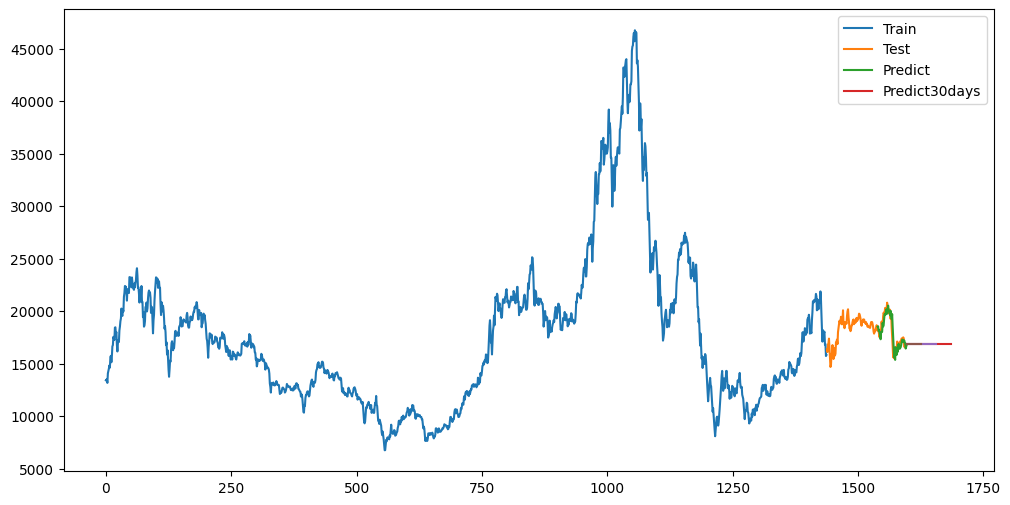

In [53]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))

prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()